# Exploratory Data Analysis (EDA) in BigQuery

In [27]:
!pip install --quiet openpyxl pandas-gbq

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-python-client 1.8.0 requires google-api-core<2dev,>=1.13.0, but you have google-api-core 2.24.0 which is incompatible.


In [13]:
import pandas as pd

## Data Ingestion

In [29]:
df = pd.read_excel("raw.xlsx")

In [34]:
df = df.dropna()
df = df.convert_dtypes()
df['CustomerID'] = df['CustomerID'].astype('int64')
df['InvoiceNo'] = df['InvoiceNo'].astype('string')
df['StockCode'] = df['StockCode'].astype('string')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  string        
 1   StockCode    406829 non-null  string        
 2   Description  406829 non-null  string        
 3   Quantity     406829 non-null  Int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  Float64       
 6   CustomerID   406829 non-null  int64         
 7   Country      406829 non-null  string        
dtypes: Float64(1), Int64(1), datetime64[ns](1), int64(1), string(4)
memory usage: 28.7 MB


In [36]:
df.to_gbq(
    destination_table='demonstration.retail',
    project_id='bigquery-plus-jupyter',
    if_exists='replace'
)

/var/tmp/ipykernel_5635/1348256002.py:1: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq(
100%|██████████| 1/1 [00:00<00:00, 7157.52it/s]


## Data Preparation

In [37]:
%%bigquery
CREATE OR REPLACE TABLE `demonstration.retail_clean`
AS (
    SELECT
        CustomerID AS customer_id,
        Country AS customer_country,
        EXTRACT(DATE FROM InvoiceDate) AS order_date,
        COUNT(DISTINCT InvoiceNo) AS n_purchases,
        SUM(Quantity) as order_qty,
        ROUND(SUM(UnitPrice * Quantity), 2) AS revenue
    FROM `demonstration.retail`
    WHERE
        CustomerID IS NOT NULL
        AND Quantity > 0
    GROUP BY
        customer_id,
        customer_country,
        order_date
)

Query is running:   0%|          |

""


In [38]:
%%bigquery
CREATE OR REPLACE TABLE `demonstration.retail_ml`
AS (
    WITH features AS (
      SELECT
        customer_id,
        customer_country,
        COUNT(n_purchases) AS n_purchases,
        AVG(order_qty) AS avg_purchase_size,
        AVG(revenue) AS avg_purchase_revenue,
        DATE_DIFF(MAX(order_date), MIN(order_date), DAY) as customer_age,
        DATE_DIFF(DATE('2011-09-01'), MAX(order_date), DAY) as days_since_last_purchase
      FROM `demonstration.retail_clean`
      WHERE order_date <= DATE('2011-09-01')
      GROUP BY
        customer_id,
        customer_country
    ),
    label AS (
      SELECT customer_id, SUM(revenue) AS target_monetary_value_3M
      FROM `demonstration.retail_clean`
      WHERE order_date < DATE('2011-12-01')
      GROUP BY customer_id
    )

    SELECT
      features.customer_id,
      features.customer_country,
      features.n_purchases, -- frequency
      features.avg_purchase_size, --monetary
      features.avg_purchase_revenue, --monetary
      features.customer_age,
      features.days_since_last_purchase, --recency
      label.target_monetary_value_3M, --target
      CASE
        WHEN MOD(ABS(FARM_FINGERPRINT(CAST(features.customer_id AS STRING))), 10) < 8
          THEN 'TRAIN'
        WHEN MOD(ABS(FARM_FINGERPRINT(CAST(features.customer_id AS STRING))), 10) = 9
          THEN 'VALIDATE'
        ELSE
          'TEST' END AS data_split
    FROM features
    INNER JOIN label ON features.customer_id = label.customer_id
)

Query is running:   0%|          |

""


## Data Analysis

In [39]:
%%bigquery recency

SELECT days_since_last_purchase
FROM `demonstration.retail_ml`

Query is running:   0%|          |

Downloading:   0%|          |

In [40]:
recency.describe()

,days_since_last_purchase
count,3330.0
mean,92.521021
std,77.240666
min,0.0
25%,27.0
50%,73.0
75%,146.75
max,274.0


array([[<Axes: title={'center': 'days_since_last_purchase'}>]],
      dtype=object)

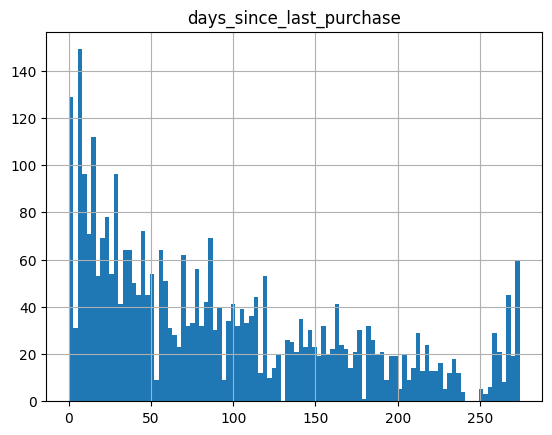

In [41]:
recency.hist(bins=100)

In [42]:
%%bigquery frequency
SELECT n_purchases
FROM `demonstration.retail_ml`

Query is running:   0%|          |

Downloading:   0%|          |

In [43]:
frequency.describe()

,n_purchases
count,3330.0
mean,3.134234
std,4.504362
min,1.0
25%,1.0
50%,2.0
75%,3.0
max,81.0


array([[<Axes: title={'center': 'n_purchases'}>]], dtype=object)

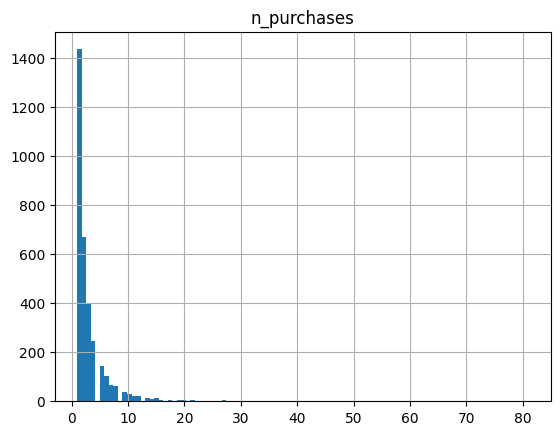

In [44]:
frequency.hist(bins=100)